In [1]:
import pandas as pd
import numpy as np
import scipy as sp
import time
import os
import ldspec
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
from statsmodels.stats.multitest import multipletests
import statsmodels.api as sm


# autoreload
%load_ext autoreload
%autoreload 2

In [2]:
DATA_PATH = '/n/groups/price/martin/LDSPEC_data/UKBimp_337K_MAF001_chimp'
FIG_PATH = '/n/groups/price/martin/LDSPEC_data/results/fig_simu'
TAB_PATH = '/n/groups/price/martin/LDSPEC_data/results/tables'

# DF_TRAIT, DF_ANNOT, DF_PANNOT
DF_TRAIT = pd.read_csv('/n/groups/price/martin/LDSPEC_data/results/tables/trait_info.tsv', sep='\t')
DF_TRAIT.index = DF_TRAIT['Trait_Identifier']
TRAIT_LIST = list(DF_TRAIT.index)
TRAIT_LIST_INDPT = list(DF_TRAIT.index[DF_TRAIT['Indpt']])
print("n_trait=%d" % DF_TRAIT.shape[0])
print("n_trait_indpt=%d" % len(TRAIT_LIST_INDPT))

DF_ANNOT = pd.read_csv('/n/groups/price/martin/LDSPEC_data/results/tables/annot_info.tsv', sep='\t')
DF_ANNOT.index = DF_ANNOT['Identifier']
print("n_annot=%d" % DF_ANNOT.shape[0])

DF_PANNOT = pd.read_csv('/n/groups/price/martin/LDSPEC_data/results/tables/pannot_info.tsv', sep='\t')
DF_PANNOT.index = DF_PANNOT['Identifier']
print("n_pannot=%d" % DF_PANNOT.shape[0])

# Others
temp_df = pd.read_csv('../names.tsv', sep='\t', header=None)
DIC_NAME = {x:y for x,y in zip(temp_df[0], temp_df[1])}
DIC_COLOR = {'common_common' : '#78ADD2', 'common' : '#78ADD2', 'common_lf' : '#80C680',
             'lf_lf' : '#FFB26E', 'lf' : '#FFB26E'}
MARKER_LIST=['o', 'v', '^', '8', 's', 'p', '*', 'h', 'H', 'D', 'd', '<', '>']

n_trait=70
n_trait_indpt=29
n_annot=45
n_pannot=34


In [3]:
# LDSPEC results
DATA_PATH = '/n/groups/price/martin/LDSPEC_data/UKBimp_337K_MAF001_chimp/simulation.100123'
DIC_RES_PATH = {}

# gene, fct, prox
DIC_RES_PATH['null_h2g50_p20'] = {
    'truth' : DATA_PATH + '/null_h2g50_p20/rep@',
    'md_prox_gene_fct_all_ld' : DATA_PATH + '/null_h2g50_p20.prox_gene_fct_all_ld/rep@',
    'md_bsl' : DATA_PATH + '/null_h2g50_p20.bsl/rep@',
}

DIC_RES_PATH['null_h2g50_p10'] = {
    'truth' : DATA_PATH + '/null_h2g50_p10/rep@',
    'md_prox_gene_fct_all_ld' : DATA_PATH + '/null_h2g50_p10.prox_gene_fct_all_ld/rep@',
}

DIC_RES_PATH['null_h2g20_p20'] = {
    'truth' : DATA_PATH + '/null_h2g20_p20/rep@',
    'md_prox_gene_fct_all_ld' : DATA_PATH + '/null_h2g20_p20.prox_gene_fct_all_ld/rep@',
}

DIC_RES_PATH['causal_h2g50_p20'] = {
    'truth' : DATA_PATH + '/causal_h2g50_p20/rep@',
    'md_prox_gene_fct_all_ld' : DATA_PATH + '/causal_h2g50_p20.prox_gene_fct_all_ld/rep@',
    'md_bsl' : DATA_PATH + '/causal_h2g50_p20.bsl/rep@',
}

DIC_RES_PATH['causal_h2g50_p10'] = {
    'truth' : DATA_PATH + '/causal_h2g50_p10/rep@',
    'md_prox_gene_fct_all_ld' : DATA_PATH + '/causal_h2g50_p10.prox_gene_fct_all_ld/rep@',
}

DIC_RES_PATH['causal_h2g20_p20'] = {
    'truth' : DATA_PATH + '/causal_h2g20_p20/rep@',
    'md_prox_gene_fct_all_ld' : DATA_PATH + '/causal_h2g20_p20.prox_gene_fct_all_ld/rep@',
}

DIC_RES_PATH['causal_pos_h2g50_p20'] = {
    'truth' : DATA_PATH + '/causal_pos_h2g50_p20/rep@',
    'md_prox_gene_fct_all_ld' : DATA_PATH + '/causal_pos_h2g50_p20.prox_gene_fct_all_ld/rep@',
}

DIC_RES_PATH['causal_neg_h2g50_p20'] = {
    'truth' : DATA_PATH + '/causal_neg_h2g50_p20/rep@',
    'md_prox_gene_fct_all_ld' : DATA_PATH + '/causal_neg_h2g50_p20.prox_gene_fct_all_ld/rep@',
}

### Read results 

In [4]:
dic_res = {}
dic_n_rep = {}

for simu in DIC_RES_PATH:
    dic_n_rep[simu] = 0
    for i_rep in range(100):
        if os.path.exists(DIC_RES_PATH[simu]['truth'].replace('@','%d'%i_rep)+'.sumstats.gz'):
            dic_n_rep[simu] = i_rep + 1
        else:
            break           
        
    dic_res[simu] = {}
    for i_rep in range(dic_n_rep[simu]):
        dic_res[simu][i_rep] = {}
        for md in DIC_RES_PATH[simu]:
            dic_res[simu][i_rep][md] = {}
            if md == 'truth':
                for res in ['tau', 'omega']:
                    dic_res[simu][i_rep]['truth'][res] = pd.read_csv(
                        DIC_RES_PATH[simu]['truth'].replace('@','%d'%i_rep)+'.eff_%s.tsv' % res, 
                        sep='\t', index_col=0
                    )
            else:
                if os.path.exists(DIC_RES_PATH[simu][md].replace('@','%d'%i_rep)+'.tau.tsv') is False:
                    print('Missing: ', DIC_RES_PATH[simu][md].replace('@','%d'%i_rep)+'.tau.tsv')
                    continue
                for res in ['tau', 'omega']:                
                    dic_res[simu][i_rep][md][res] = pd.read_csv(
                        DIC_RES_PATH[simu][md].replace('@','%d'%i_rep)+'.%s.tsv' % res, sep='\t', index_col=0
                )
    
    # Print h2
    for md in DIC_RES_PATH[simu]:
        if md=='truth': 
            continue
        v_ = np.array([dic_res[simu][x][md]['tau'].loc['AN:all', 'h2'] for x in range(dic_n_rep[simu])])
        v_se = np.array([dic_res[simu][x][md]['tau'].loc['AN:all', 'h2_se'] for x in range(dic_n_rep[simu])])
        v_true = np.array([dic_res[simu][0]['truth']['tau'].loc['AN:all', 'h2'] for x in range(dic_n_rep[simu])])
        print('%-20s n_rep=%d \t %-20s h2=%0.3f, h2_true=%0.3f, avg_jnse=%0.3f, empi_se=%0.3f' %(
            simu, dic_n_rep[simu], md, np.mean(v_), np.mean(v_true), np.mean(v_se), np.std(v_)
        ))

null_h2g50_p20       n_rep=50 	 md_prox_gene_fct_all_ld h2=0.507, h2_true=0.496, avg_jnse=0.018, empi_se=0.015
null_h2g50_p20       n_rep=50 	 md_bsl               h2=0.506, h2_true=0.496, avg_jnse=0.017, empi_se=0.011
null_h2g50_p10       n_rep=50 	 md_prox_gene_fct_all_ld h2=0.511, h2_true=0.501, avg_jnse=0.017, empi_se=0.013
null_h2g20_p20       n_rep=50 	 md_prox_gene_fct_all_ld h2=0.202, h2_true=0.198, avg_jnse=0.008, empi_se=0.007
causal_h2g50_p20     n_rep=50 	 md_prox_gene_fct_all_ld h2=0.370, h2_true=0.354, avg_jnse=0.015, empi_se=0.010
causal_h2g50_p20     n_rep=50 	 md_bsl               h2=0.364, h2_true=0.354, avg_jnse=0.014, empi_se=0.009
causal_h2g50_p10     n_rep=50 	 md_prox_gene_fct_all_ld h2=0.364, h2_true=0.336, avg_jnse=0.021, empi_se=0.012
causal_h2g20_p20     n_rep=50 	 md_prox_gene_fct_all_ld h2=0.127, h2_true=0.120, avg_jnse=0.006, empi_se=0.005
causal_pos_h2g50_p20 n_rep=50 	 md_prox_gene_fct_all_ld h2=0.511, h2_true=0.507, avg_jnse=0.026, empi_se=0.019
causal_

In [5]:
# Supp. Table for null and causal simulations and all quantities
term_list = [
    ['tau', 'tau', 0], ['tau', 'h2', 0], ['tau', 'scv', 0], 
    ['tau', 'h2_enrich', 1], ['tau', 'scv_enrich', 1], ['tau', 'h2_shrink', 1], 
    ['omega', 'omega', 0], ['omega', 'cov', 0], ['omega', 'cor', 0], ['omega', 'ecov', 0], ['omega', 'ecor', 0],
]
col_list = [
    'annot', 'term', 'term_identifier', 'truth', 'jnse', 
    'empi.mean', 'empi.se', 'empi.p', 'empi.fwer', 'empi.sig_str',
    'meta.mean', 'meta.se', 'meta.p', 'meta.fwer', 'meta.sig_str'
]

DIC_SUMMARY = {}
for simu in DIC_RES_PATH:
    DIC_SUMMARY[simu] = {}
    for md in DIC_RES_PATH[simu]: 
        if md == 'truth':
            continue
        DIC_SUMMARY[simu][md] = None
        res_tau_list = [dic_res[simu][x][md]['tau'] for x in range(dic_n_rep[simu])]
        res_omega_list = [dic_res[simu][x][md]['omega'] for x in range(dic_n_rep[simu])]
        for res,term,null_val in term_list:
            temp_df = pd.DataFrame(index=dic_res[simu][0][md][res].index, columns=col_list, dtype=float)
            temp_df['annot'] = temp_df.index
            temp_df['term'] = DIC_NAME[term]
            temp_df['term_identifier'] = term
            for row in temp_df.index:
                # empi.mean & empi.se
                v_ = [dic_res[simu][x][md][res].loc[row, term] for x in range(dic_n_rep[simu])]
                temp_df.loc[row, 'empi.mean'] = np.mean(v_)
                temp_df.loc[row, 'empi.se'] = np.std(v_) / np.sqrt(dic_n_rep[simu])
                # jnse
                v_se_ = [dic_res[simu][x][md][res].loc[row, '%s_se'%term] for x in range(dic_n_rep[simu])]
                temp_df.loc[row, 'jnse'] = np.sqrt(np.mean(np.array(v_se_)**2)) / np.sqrt(dic_n_rep[simu])
                # truth
                if row in dic_res[simu][0]['truth'][res].index: 
                    v_ = [dic_res[simu][x]['truth'][res].loc[row, term] for x in range(dic_n_rep[simu])]
                    temp_df.loc[row, 'truth'] = np.mean(v_)
                if simu.startswith('null') & (term in ['tau', 'omega', 'cov', 'cor', 'ecor']):
                    temp_df.loc[temp_df['truth'].isna(), 'truth'] = null_val
                if simu.startswith('causal') & (term in ['tau', 'omega']):
                    temp_df.loc[temp_df['truth'].isna(), 'truth'] = null_val
                if simu.startswith('causal') & (term in ['ecor']) & row.startswith('pAN:proxy'):
                    temp_df.loc[row, 'truth'] = 0                         
                # meta-analysis                
                mean_,se_,p_ = ldspec.util.ldspec_meta(res_tau_list, res_omega_list, term, row)
                temp_df.loc[row, ['meta.mean', 'meta.se', 'meta.p']] = mean_,se_,p_
            
            # multiple testing: meta
            temp_df['meta.fwer'] = temp_df['meta.p'] * temp_df.shape[0]
            temp_df['meta.sig_str'] = ['*' if x<0.05 else '' for x in temp_df['meta.fwer']]  
            # multiple testing: empi
            temp_z = np.array((temp_df['empi.mean']-null_val) / temp_df['empi.se'])
            temp_df['empi.p'] = ldspec.util.zsc2pval(temp_z)
            temp_df['empi.fwer'] = temp_df['empi.p'] * temp_df.shape[0]
            temp_df['empi.sig_str'] = ['*' if x<0.05 else '' for x in temp_df['empi.fwer']]

            if DIC_SUMMARY[simu][md] is None:
                DIC_SUMMARY[simu][md] = temp_df.copy()
            else:
                DIC_SUMMARY[simu][md] = pd.concat([DIC_SUMMARY[simu][md], temp_df], axis=0)

/home/jz286/WES_analysis/LDSPEC/ldspec/util.py:102: RuntimeWarning: divide by zero encountered in true_divide
  vwts = 1.0 / variances
/home/jz286/WES_analysis/LDSPEC/ldspec/util.py:106: RuntimeWarning: invalid value encountered in float_scalars
  tau2 = np.maximum(0, (Q - df) / (vwts.sum() - vwts.dot(vwts) / vwts.sum()))
/home/jz286/WES_analysis/LDSPEC/ldspec/util.py:122: RuntimeWarning: overflow encountered in multiply
  varsum = np.sum(wt * wt * (variances + tau2)) / (np.sum(wt) ** 2)


### Supp. Fig. : rho & cor & ecor straified by MAF

In [6]:
term_list = [['omega', 'omega', 0], ['omega', 'cor', 0], ['omega', 'ecor', 0]]
dic_name = {
    'null_h2g50_p20' : 'null (SCV=0.5 p_causal=0.2)', 
    'null_h2g50_p10' : 'null (SCV=0.5 p_causal=0.1)',
    'null_h2g20_p20' : 'null (SCV=0.2 p_causal=0.2)',
    'causal_h2g50_p20' : 'causal (SCV=0.5 p_causal=0.2)', 
    'causal_h2g50_p10' : 'causal (SCV=0.5 p_causal=0.1)',
    'causal_h2g20_p20' : 'causal (SCV=0.2 p_causal=0.2)',
    'causal_pos_h2g50_p20' : 'causal-pos (SCV=0.5 p_causal=0.2)',
    'causal_neg_h2g50_p20' : 'causal-neg (SCV=0.5 p_causal=0.2)',
    ('p0_p100', 'common') : 'common pos-LD',
    ('p0_p100', 'lf') : 'low-freq pos-LD',
    ('n100_p0', 'common') : 'common neg-LD',
    ('n100_p0', 'lf') : 'low-freq neg-LD',
}

simu_md_list = [
    ['null_h2g50_p20', 'md_prox_gene_fct_all_ld'], 
    ['null_h2g50_p10', 'md_prox_gene_fct_all_ld'], 
    ['null_h2g20_p20', 'md_prox_gene_fct_all_ld'], 
    ['causal_h2g50_p20', 'md_prox_gene_fct_all_ld'], 
    ['causal_h2g50_p10', 'md_prox_gene_fct_all_ld'], 
    ['causal_h2g20_p20', 'md_prox_gene_fct_all_ld'], 
    ['causal_pos_h2g50_p20', 'md_prox_gene_fct_all_ld'], 
    ['causal_neg_h2g50_p20', 'md_prox_gene_fct_all_ld'], 
]

null_h2g50_p20 md_prox_gene_fct_all_ld 34


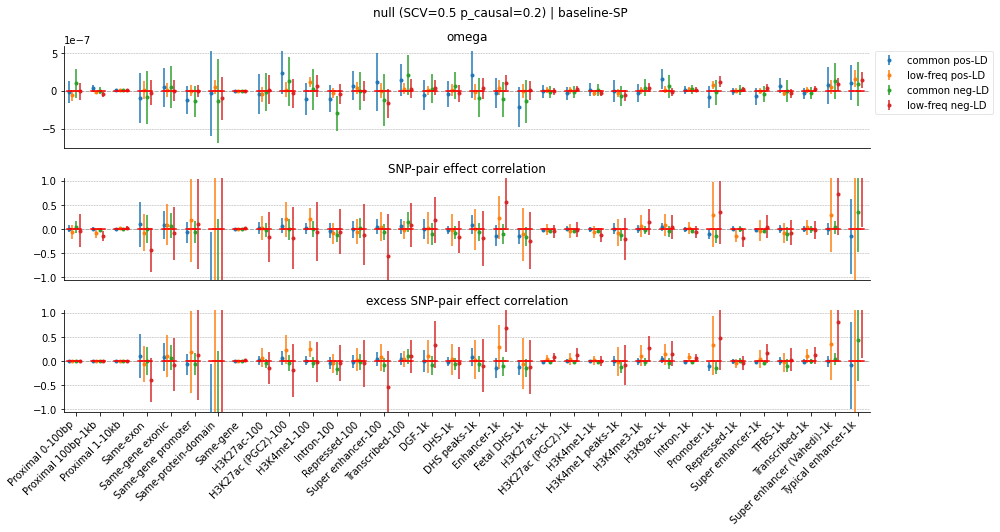

null_h2g50_p10 md_prox_gene_fct_all_ld 34


,term_identifier,truth,empi.mean,empi.se,empi.p,empi.fwer
pAN:proxy_100_1000_ld_n100_p0_maf_common_block,omega,0.0,9.447700e-08,2.512632e-08,0.000170,0.023101
pAN:protein_domain_ld_n100_p0_maf_lf_block,omega,0.0,5.433167e-07,1.386619e-07,0.000089,0.012129


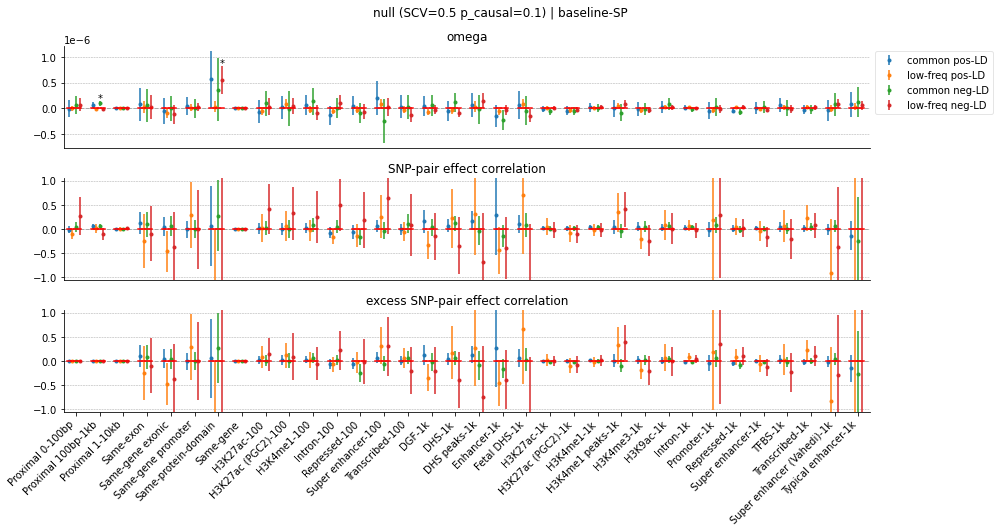

null_h2g20_p20 md_prox_gene_fct_all_ld 34


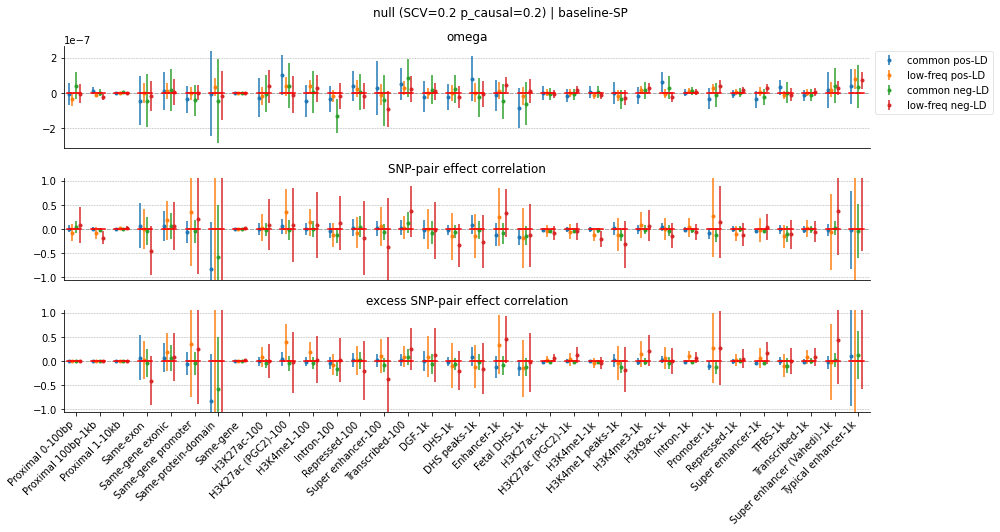

causal_h2g50_p20 md_prox_gene_fct_all_ld 34


,term_identifier,truth,empi.mean,empi.se,empi.p,empi.fwer
pAN:proxy_1000_10000_ld_p0_p100_maf_lf_block,omega,0.000000e+00,-5.166336e-09,1.229350e-09,2.639921e-05,3.590293e-03
pAN:proxy_1000_10000_ld_n100_p0_maf_common_block,omega,0.000000e+00,1.031168e-08,2.302578e-09,7.523383e-06,1.023180e-03
pAN:Intron_UCSC_proxy_0_1000_ld_p0_p100_maf_common_block,omega,0.000000e+00,8.621406e-08,1.501034e-08,9.266117e-09,1.260192e-06
pAN:SuperEnhancer_Hnisz_proxy_0_1000_ld_p0_p100_maf_common_block,omega,-7.054527e-07,-1.177408e-07,2.956486e-08,6.820677e-05,9.276121e-03
pAN:Intron_UCSC_proxy_0_1000_ld_n100_p0_maf_common_block,omega,0.000000e+00,1.109081e-07,1.666987e-08,2.867712e-11,3.900089e-09


,term_identifier,truth,empi.mean,empi.se,empi.p,empi.fwer
pAN:proxy_0_100_ld_p0_p100_maf_common_block,cor,-0.415064,-0.158029,0.034589,4.907092e-06,6.673645e-04
pAN:proxy_100_1000_ld_p0_p100_maf_common_block,cor,-0.269274,-0.089836,0.016082,2.321123e-08,3.156727e-06
pAN:proxy_1000_10000_ld_n100_p0_maf_common_block,cor,NaN,0.015853,0.003683,1.673790e-05,2.276354e-03
pAN:H3K27ac_PGC2_proxy_0_100_ld_p0_p100_maf_common_block,cor,NaN,-0.179967,0.050194,3.365276e-04,4.576775e-02
pAN:H3K4me1_Trynka_proxy_0_100_ld_p0_p100_maf_common_block,cor,NaN,-0.193026,0.048895,7.889402e-05,1.072959e-02
pAN:SuperEnhancer_Hnisz_proxy_0_100_ld_p0_p100_maf_common_block,cor,NaN,-0.205027,0.056199,2.640242e-04,3.590729e-02
pAN:H3K27ac_Hnisz_proxy_0_1000_ld_p0_p100_maf_common_block,cor,NaN,-0.129401,0.017031,3.012562e-14,4.097085e-12
pAN:H3K27ac_Hnisz_proxy_0_1000_ld_p0_p100_maf_lf_block,cor,NaN,-0.173514,0.046724,2.043433e-04,2.779068e-02
pAN:H3K27ac_PGC2_proxy_0_1000_ld_p0_p100_maf_common_block,cor,NaN,-0.135975,0.017746,1.824531e-14,2.481362e-12
pAN:H3K4me1_Trynka_proxy_0_1000_ld_p0_p100_maf_common_block,cor,NaN,-0.132674,0.020886,2.119291e-10,2.882236e-08


,term_identifier,truth,empi.mean,empi.se,empi.p,empi.fwer
pAN:H3K27ac_Hnisz_proxy_0_1000_ld_p0_p100_maf_common_block,ecor,NaN,-0.059933,0.011001,5.100750e-08,6.937020e-06
pAN:H3K27ac_Hnisz_proxy_0_1000_ld_p0_p100_maf_lf_block,ecor,NaN,-0.128852,0.032492,7.318790e-05,9.953555e-03
pAN:H3K27ac_PGC2_proxy_0_1000_ld_p0_p100_maf_common_block,ecor,NaN,-0.066872,0.014450,3.696256e-06,5.026909e-04
pAN:H3K4me1_Trynka_proxy_0_1000_ld_p0_p100_maf_common_block,ecor,NaN,-0.056854,0.015644,2.787492e-04,3.790989e-02
pAN:SuperEnhancer_Hnisz_proxy_0_1000_ld_p0_p100_maf_common_block,ecor,-0.217450,-0.101381,0.015224,2.755639e-11,3.747668e-09
pAN:SuperEnhancer_Hnisz_proxy_0_1000_ld_p0_p100_maf_lf_block,ecor,-0.156005,-0.208640,0.057867,3.115038e-04,4.236451e-02
pAN:Intron_UCSC_proxy_0_1000_ld_n100_p0_maf_common_block,ecor,NaN,0.061175,0.013512,5.969296e-06,8.118243e-04


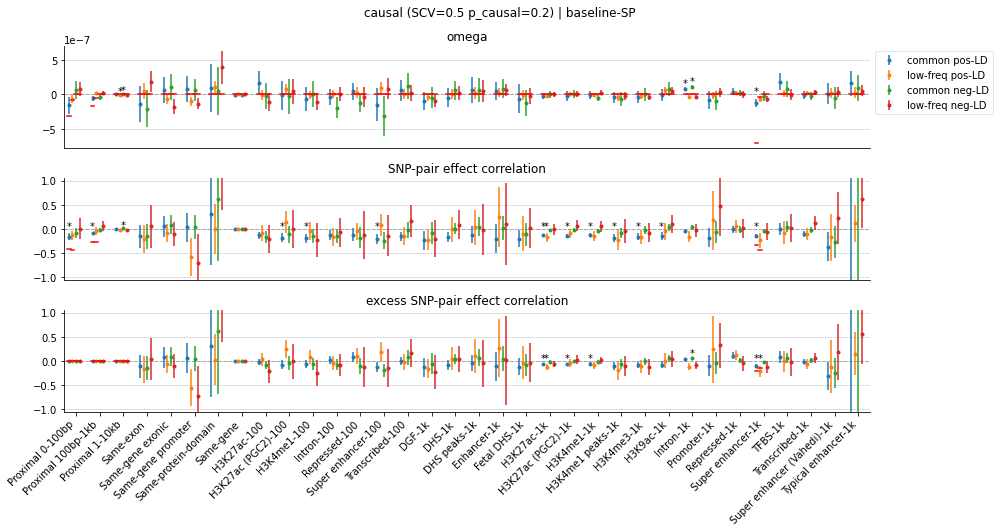

causal_h2g50_p10 md_prox_gene_fct_all_ld 34


,term_identifier,truth,empi.mean,empi.se,empi.p,empi.fwer
pAN:Intron_UCSC_proxy_0_1000_ld_p0_p100_maf_lf_block,omega,0.000000e+00,-4.920151e-08,1.146831e-08,0.000018,0.002428
pAN:SuperEnhancer_Hnisz_proxy_0_1000_ld_p0_p100_maf_common_block,omega,-7.133226e-07,-1.611197e-07,4.329180e-08,0.000198,0.026911
pAN:Intron_UCSC_proxy_0_1000_ld_n100_p0_maf_lf_block,omega,0.000000e+00,-5.431616e-08,1.428559e-08,0.000143,0.019508


,term_identifier,truth,empi.mean,empi.se,empi.p,empi.fwer
pAN:proxy_0_100_ld_p0_p100_maf_lf_block,cor,-0.432254,-0.222342,0.055332,5.861165e-05,7.971185e-03
pAN:H3K27ac_Hnisz_proxy_0_1000_ld_p0_p100_maf_common_block,cor,NaN,-0.128938,0.023457,3.866475e-08,5.258406e-06
pAN:SuperEnhancer_Hnisz_proxy_0_1000_ld_p0_p100_maf_common_block,cor,-0.331938,-0.164709,0.025644,1.336735e-10,1.817960e-08
pAN:Transcribed_Hoffman_proxy_0_1000_ld_p0_p100_maf_common_block,cor,NaN,-0.137169,0.038441,3.593718e-04,4.887456e-02
pAN:Vahedi_Tcell_SE_proxy_0_1000_ld_p0_p100_maf_lf_block,cor,NaN,-0.670405,0.149733,7.558095e-06,1.027901e-03


,term_identifier,truth,empi.mean,empi.se,empi.p,empi.fwer
pAN:H3K27ac_Hnisz_proxy_0_1000_ld_p0_p100_maf_common_block,ecor,NaN,-0.066490,0.017511,1.464640e-04,0.019919
pAN:Intron_UCSC_proxy_0_1000_ld_p0_p100_maf_lf_block,ecor,NaN,-0.151805,0.036386,3.018912e-05,0.004106
pAN:SuperEnhancer_Hnisz_proxy_0_1000_ld_p0_p100_maf_common_block,ecor,-0.219386,-0.120911,0.021520,1.926696e-08,0.000003
pAN:Vahedi_Tcell_SE_proxy_0_1000_ld_p0_p100_maf_lf_block,ecor,NaN,-0.678106,0.141507,1.651096e-06,0.000225


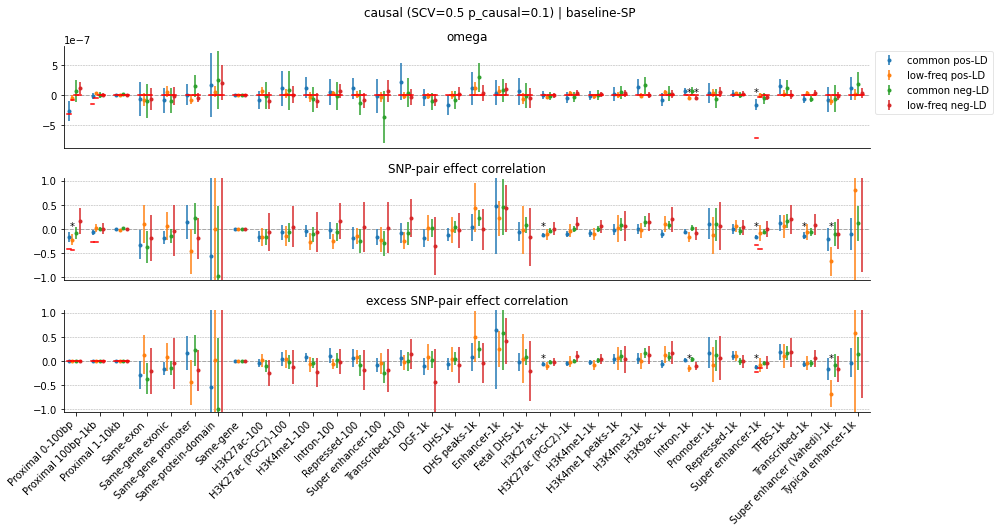

causal_h2g20_p20 md_prox_gene_fct_all_ld 34


,term_identifier,truth,empi.mean,empi.se,empi.p,empi.fwer
pAN:proxy_1000_10000_ld_n100_p0_maf_common_block,omega,0.000000e+00,3.367664e-09,8.831486e-10,1.371528e-04,0.018653
pAN:Intron_UCSC_proxy_0_1000_ld_p0_p100_maf_common_block,omega,0.000000e+00,3.095297e-08,5.836313e-09,1.135941e-07,0.000015
pAN:SuperEnhancer_Hnisz_proxy_0_1000_ld_p0_p100_maf_common_block,omega,-2.410500e-07,-4.293490e-08,1.092594e-08,8.507615e-05,0.011570
pAN:Intron_UCSC_proxy_0_1000_ld_n100_p0_maf_common_block,omega,0.000000e+00,3.965885e-08,7.003364e-09,1.488978e-08,0.000002


,term_identifier,truth,empi.mean,empi.se,empi.p,empi.fwer
pAN:proxy_0_100_ld_p0_p100_maf_common_block,cor,-0.415064,-0.167945,0.037021,5.721315e-06,7.780989e-04
pAN:proxy_100_1000_ld_p0_p100_maf_common_block,cor,-0.269274,-0.089614,0.018536,1.334382e-06,1.814760e-04
pAN:proxy_1000_10000_ld_n100_p0_maf_common_block,cor,NaN,0.015389,0.004171,2.247790e-04,3.056994e-02
pAN:H3K27ac_Hnisz_proxy_0_100_ld_p0_p100_maf_common_block,cor,NaN,-0.150262,0.038674,1.021858e-04,1.389727e-02
pAN:H3K27ac_PGC2_proxy_0_100_ld_p0_p100_maf_common_block,cor,NaN,-0.196131,0.050641,1.075049e-04,1.462066e-02
pAN:H3K4me1_Trynka_proxy_0_100_ld_p0_p100_maf_common_block,cor,NaN,-0.207208,0.049864,3.246404e-05,4.415109e-03
pAN:SuperEnhancer_Hnisz_proxy_0_100_ld_p0_p100_maf_common_block,cor,NaN,-0.221260,0.058275,1.465790e-04,1.993474e-02
pAN:H3K27ac_Hnisz_proxy_0_1000_ld_p0_p100_maf_common_block,cor,NaN,-0.128993,0.019173,1.720437e-11,2.339795e-09
pAN:H3K27ac_Hnisz_proxy_0_1000_ld_p0_p100_maf_lf_block,cor,NaN,-0.195820,0.053491,2.513925e-04,3.418939e-02
pAN:H3K27ac_PGC2_proxy_0_1000_ld_p0_p100_maf_common_block,cor,NaN,-0.141978,0.019787,7.206732e-13,9.801156e-11


,term_identifier,truth,empi.mean,empi.se,empi.p,empi.fwer
pAN:H3K27ac_Hnisz_proxy_0_1000_ld_p0_p100_maf_common_block,ecor,NaN,-0.058474,0.012213,1.684269e-06,2.290606e-04
pAN:H3K27ac_Hnisz_proxy_0_1000_ld_p0_p100_maf_lf_block,ecor,NaN,-0.134910,0.033113,4.615878e-05,6.277594e-03
pAN:H3K27ac_PGC2_proxy_0_1000_ld_p0_p100_maf_common_block,ecor,NaN,-0.073359,0.015432,1.995840e-06,2.714342e-04
pAN:SuperEnhancer_Hnisz_proxy_0_1000_ld_p0_p100_maf_common_block,ecor,-0.21745,-0.106459,0.017269,7.065742e-10,9.609409e-08
pAN:Intron_UCSC_proxy_0_1000_ld_n100_p0_maf_common_block,ecor,NaN,0.062065,0.015918,9.657373e-05,1.313403e-02


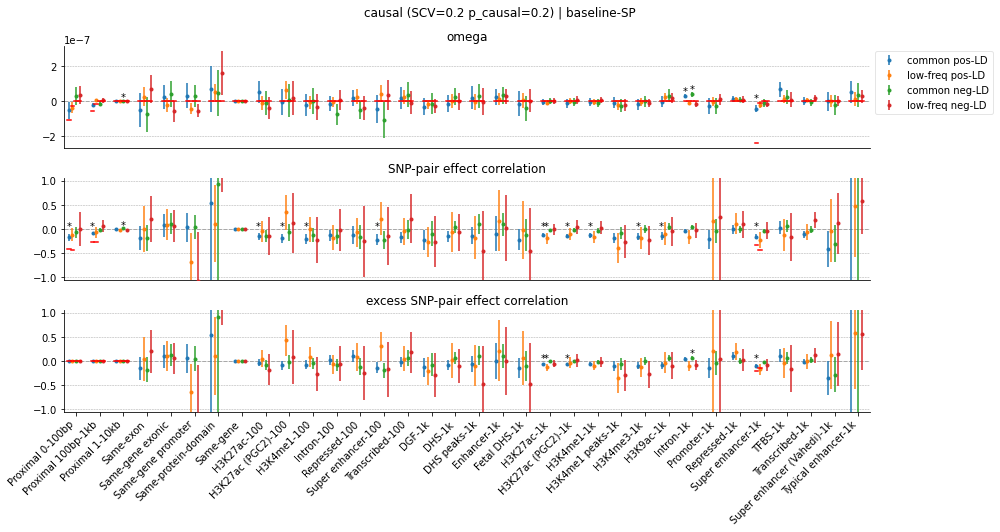

causal_pos_h2g50_p20 md_prox_gene_fct_all_ld 34


,term_identifier,truth,empi.mean,empi.se,empi.p,empi.fwer
pAN:proxy_100_1000_ld_p0_p100_maf_common_block,omega,1.541754e-07,1.793570e-07,4.089755e-08,1.157098e-05,1.573654e-03
pAN:proxy_100_1000_ld_n100_p0_maf_common_block,omega,1.528470e-07,1.478067e-07,3.372278e-08,1.170591e-05,1.592004e-03
pAN:SuperEnhancer_Hnisz_proxy_0_1000_ld_p0_p100_maf_common_block,omega,9.135730e-07,6.783956e-07,1.356032e-07,5.650359e-07,7.684488e-05
pAN:SuperEnhancer_Hnisz_proxy_0_1000_ld_n100_p0_maf_common_block,omega,9.027695e-07,6.541427e-07,1.128456e-07,6.759500e-09,9.192920e-07


,term_identifier,truth,empi.mean,empi.se,empi.p,empi.fwer
pAN:proxy_0_100_ld_p0_p100_maf_common_block,cor,0.624327,0.402048,0.084349,1.874957e-06,2.549942e-04
pAN:proxy_0_100_ld_p0_p100_maf_lf_block,cor,0.539627,0.369841,0.076335,1.266279e-06,1.722140e-04
pAN:proxy_100_1000_ld_p0_p100_maf_common_block,cor,0.395507,0.487118,0.042714,3.979600e-30,5.412256e-28
pAN:proxy_0_100_ld_n100_p0_maf_common_block,cor,0.621211,0.631162,0.087692,6.134484e-13,8.342898e-11
pAN:proxy_100_1000_ld_n100_p0_maf_common_block,cor,0.396948,0.446478,0.036679,4.350049e-34,5.916066e-32
pAN:H3K27ac_Hnisz_proxy_0_100_ld_p0_p100_maf_common_block,cor,NaN,0.462100,0.110212,2.755052e-05,3.746871e-03
pAN:H3K27ac_Hnisz_proxy_0_100_ld_p0_p100_maf_lf_block,cor,NaN,0.573156,0.151849,1.603237e-04,2.180403e-02
pAN:Repressed_Hoffman_proxy_0_100_ld_p0_p100_maf_lf_block,cor,NaN,0.554040,0.153520,3.074912e-04,4.181880e-02
pAN:SuperEnhancer_Hnisz_proxy_0_100_ld_p0_p100_maf_common_block,cor,NaN,0.605058,0.148656,4.697741e-05,6.388928e-03
pAN:H3K27ac_Hnisz_proxy_0_100_ld_n100_p0_maf_common_block,cor,NaN,0.734226,0.091781,1.246766e-15,1.695602e-13


,term_identifier,truth,empi.mean,empi.se,empi.p,empi.fwer
pAN:H3K27ac_Hnisz_proxy_0_100_ld_n100_p0_maf_common_block,ecor,NaN,0.301376,0.059777,4.615468e-07,6.277037e-05
pAN:SuperEnhancer_Hnisz_proxy_0_100_ld_n100_p0_maf_common_block,ecor,NaN,0.579215,0.137927,2.675793e-05,3.639078e-03
pAN:H3K27ac_Hnisz_proxy_0_1000_ld_p0_p100_maf_common_block,ecor,NaN,0.275113,0.030639,2.724576e-19,3.705423e-17
pAN:H3K27ac_PGC2_proxy_0_1000_ld_p0_p100_maf_common_block,ecor,NaN,0.273628,0.041685,5.233707e-11,7.117842e-09
pAN:H3K4me1_Trynka_proxy_0_1000_ld_p0_p100_maf_common_block,ecor,NaN,0.185911,0.036463,3.420704e-07,4.652158e-05
pAN:Repressed_Hoffman_proxy_0_1000_ld_p0_p100_maf_common_block,ecor,NaN,-0.205707,0.049714,3.505814e-05,4.767906e-03
pAN:SuperEnhancer_Hnisz_proxy_0_1000_ld_p0_p100_maf_common_block,ecor,0.381906,0.433974,0.058397,1.074098e-13,1.460773e-11
pAN:H3K27ac_Hnisz_proxy_0_1000_ld_n100_p0_maf_common_block,ecor,NaN,0.266208,0.026198,2.947034e-24,4.007966e-22
pAN:H3K27ac_PGC2_proxy_0_1000_ld_n100_p0_maf_common_block,ecor,NaN,0.271841,0.035337,1.439272e-14,1.957409e-12
pAN:H3K4me1_Trynka_proxy_0_1000_ld_n100_p0_maf_common_block,ecor,NaN,0.213617,0.030523,2.587444e-12,3.518923e-10


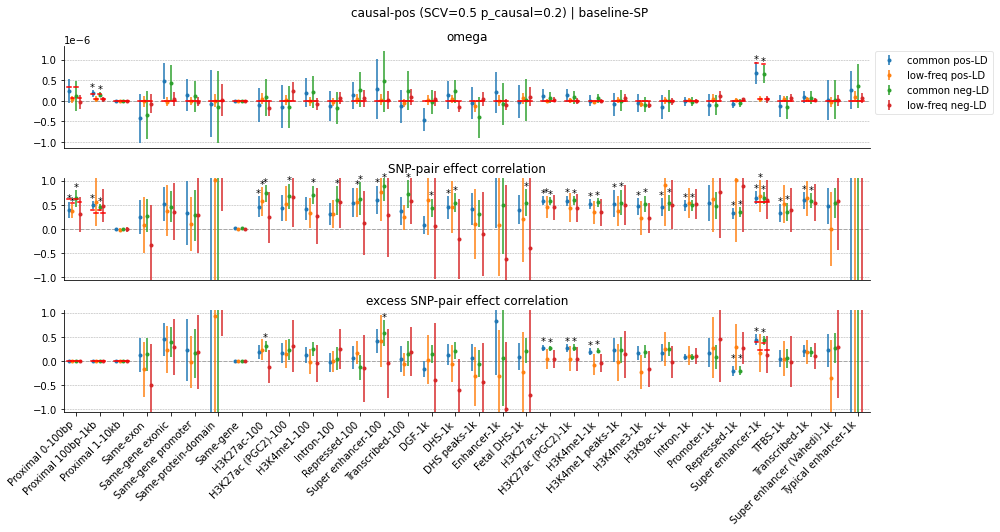

causal_neg_h2g50_p20 md_prox_gene_fct_all_ld 34


,term_identifier,truth,empi.mean,empi.se,empi.p,empi.fwer
pAN:proxy_100_1000_ld_p0_p100_maf_common_block,omega,-8.207266e-08,-1.425297e-07,3.178698e-08,0.000007,0.000997
pAN:proxy_100_1000_ld_n100_p0_maf_common_block,omega,-8.365558e-08,-1.284551e-07,3.007144e-08,0.000019,0.002639
pAN:proxy_1000_10000_ld_n100_p0_maf_common_block,omega,0.000000e+00,1.618606e-08,4.486614e-09,0.000309,0.042024
pAN:exonic_gene_ld_p0_p100_maf_common_block,omega,0.000000e+00,-6.611955e-07,1.470650e-07,0.000007,0.000942
pAN:SuperEnhancer_Hnisz_proxy_0_1000_ld_p0_p100_maf_common_block,omega,-3.349941e-07,-3.162417e-07,8.179518e-08,0.000111,0.015030


,term_identifier,truth,empi.mean,empi.se,empi.p,empi.fwer
pAN:proxy_0_100_ld_p0_p100_maf_common_block,cor,-0.281909,-0.202120,0.044555,5.720973e-06,7.780524e-04
pAN:proxy_100_1000_ld_p0_p100_maf_common_block,cor,-0.168206,-0.167827,0.033294,4.636019e-07,6.304986e-05
pAN:proxy_1000_10000_ld_p0_p100_maf_common_block,cor,NaN,0.019705,0.005389,2.556419e-04,3.476730e-02
pAN:proxy_0_100_ld_n100_p0_maf_common_block,cor,-0.287189,-0.399327,0.088171,5.925645e-06,8.058878e-04
pAN:proxy_100_1000_ld_n100_p0_maf_common_block,cor,-0.172095,-0.177044,0.026577,2.707587e-11,3.682319e-09
pAN:proxy_1000_10000_ld_n100_p0_maf_common_block,cor,NaN,0.021620,0.005372,5.716945e-05,7.775045e-03
pAN:H3K27ac_PGC2_proxy_0_100_ld_n100_p0_maf_common_block,cor,NaN,-0.538878,0.140033,1.189804e-04,1.618134e-02
pAN:Intron_UCSC_proxy_0_100_ld_n100_p0_maf_common_block,cor,NaN,-0.573611,0.134973,2.139298e-05,2.909446e-03
pAN:SuperEnhancer_Hnisz_proxy_0_100_ld_n100_p0_maf_common_block,cor,NaN,-0.539414,0.142692,1.566597e-04,2.130572e-02
pAN:Transcribed_Hoffman_proxy_0_100_ld_n100_p0_maf_common_block,cor,NaN,-0.637280,0.169479,1.697638e-04,2.308788e-02


,term_identifier,truth,empi.mean,empi.se,empi.p,empi.fwer
pAN:SuperEnhancer_Hnisz_proxy_0_1000_ld_p0_p100_maf_common_block,ecor,-0.126327,-0.137168,0.027438,5.759060e-07,0.000078
pAN:H3K27ac_PGC2_proxy_0_1000_ld_n100_p0_maf_common_block,ecor,NaN,-0.139608,0.039049,3.499784e-04,0.047597
pAN:SuperEnhancer_Hnisz_proxy_0_1000_ld_n100_p0_maf_common_block,ecor,-0.125069,-0.159637,0.031646,4.546688e-07,0.000062


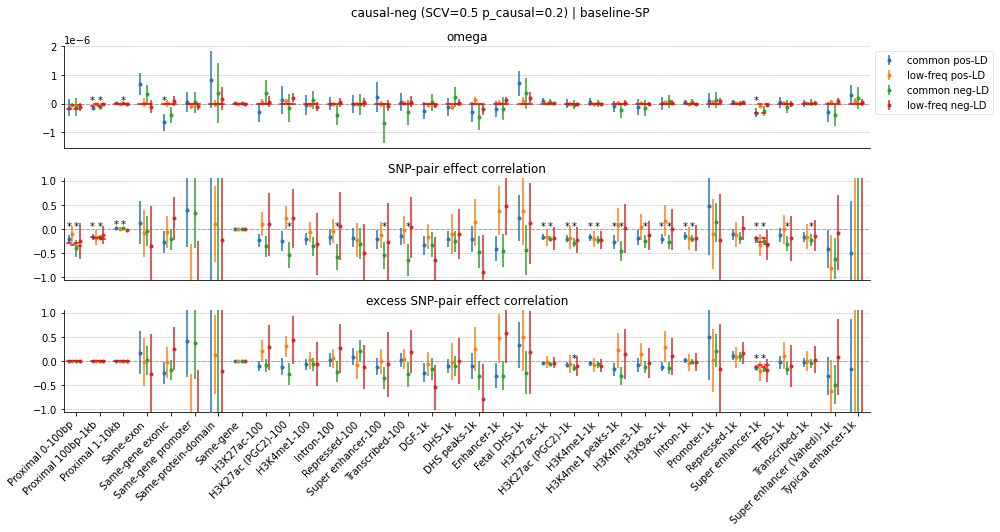

In [7]:
for simu,md in simu_md_list: 
    plot_list = [x for x in DF_PANNOT.index if 'pAN:%s_ld_n100_p0_maf_lf_block'%x in DIC_SUMMARY[simu][md].index]
    print(simu, md, len(plot_list))
    plt.figure(figsize=[14, 7.5])
    for i_plot,temp in enumerate(term_list):
        res,term,null_val = temp
        ind_select = DIC_SUMMARY[simu][md]['term_identifier']==term
        df_plot = DIC_SUMMARY[simu][md].loc[ind_select].copy()
        ind_select = df_plot['empi.sig_str']=='*'
        if ind_select.sum()>0:
            display(df_plot.loc[
                ind_select, ['term_identifier', 'truth', 'empi.mean', 'empi.se', 'empi.p', 'empi.fwer']
            ])
        ax = plt.subplot(3,1,i_plot+1)
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        
        for i_bin,(lbin,mbin) in enumerate([
            ('p0_p100', 'common'), ('p0_p100', 'lf'), ('n100_p0', 'common'), ('n100_p0', 'lf'),
        ]):
            row_list = ['pAN:%s_ld_%s_maf_%s_block'%(x,lbin,mbin) for x in plot_list]   
            plt.errorbar(
                np.arange(len(row_list))+0.15*i_bin-0.3, df_plot.loc[row_list, 'empi.mean'],
                yerr=df_plot.loc[row_list, 'empi.se']*1.96, fmt= '.', label=dic_name[(lbin,mbin)], zorder=10
            )
            for i_row,row in enumerate(row_list):
                plt.plot([i_row+0.15*i_bin-0.375, i_row+0.15*i_bin-0.225], 
                         [df_plot.loc[row, 'truth'], df_plot.loc[row, 'truth']], '-', color='r', zorder=15)
                plt.text(i_row+0.15*i_bin-0.3,
                         min(1.01, max(0, df_plot.loc[row, 'empi.mean'] + df_plot.loc[row, 'empi.se'] * 1.96)), 
                         df_plot.loc[row, 'empi.sig_str'], ha='center') 

        plt.plot([-0.5, len(plot_list)-0.5], [0, 0], '--', linewidth=1, zorder=0, color="darkgrey")
        plt.xlim([-0.5, len(plot_list)-0.5]) 
        if term in ['cor', 'ecor']:
            plt.ylim([-1.05, 1.05])
            plt.yticks([-1, -0.5, 0, 0.5, 1])
        plt.grid(axis='y', linewidth=0.5, linestyle='--', color='darkgrey', zorder=0)
            
        plt.title(DIC_NAME[term])
        if i_plot == 0:
            plt.legend(loc='upper left', framealpha=0.5, bbox_to_anchor=(1, 1))
        if i_plot <2:
            plt.xticks([], [])
        if i_plot == 2:
            plt.xticks(np.arange(len(plot_list)), [DIC_NAME[x] if x in DIC_NAME else x for x in plot_list], 
                       rotation=45, ha='right')          
    
    plt.suptitle('%s | %s' % (dic_name[simu], DIC_NAME[md] if md in DIC_NAME else md))
    plt.tight_layout()
    plt.savefig(FIG_PATH + '/other.%s.%s.pdf'%(simu,md))
    plt.show()
#     break

null_h2g50_p20 md_prox_gene_fct_all_ld 17


,term,truth,empi.mean,empi.se
AN:SuperEnhancer_Hnisz_common,tau,1.353052e-06,1.335558e-06,4.994435e-08
AN:all,tau,4.898668e-08,5.171332e-08,1.922459e-09
AN:SuperEnhancer_Hnisz_common,heritability,1.933670e-01,1.937311e-01,1.829675e-03
AN:all,heritability,4.963853e-01,5.074431e-01,2.110003e-03
AN:SuperEnhancer_Hnisz_common,sum of causal effect size variance,1.965717e-01,1.914821e-01,4.017931e-03
AN:all,sum of causal effect size variance,5.038206e-01,5.070887e-01,8.210407e-03
AN:SuperEnhancer_Hnisz_common,heritability enrichment,2.242794e+00,2.203158e+00,1.831715e-02
AN:all,heritability enrichment,NaN,NaN,NaN
AN:SuperEnhancer_Hnisz_common,SCV enrichment,2.241548e+00,2.183435e+00,4.298888e-02
AN:all,SCV enrichment,NaN,NaN,NaN


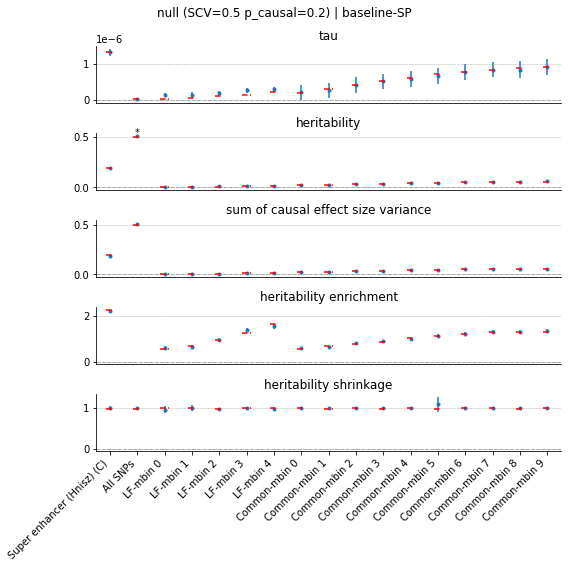

causal_h2g50_p20 md_prox_gene_fct_all_ld 17


,term,truth,empi.mean,empi.se
AN:SuperEnhancer_Hnisz_common,tau,1.903829e-06,7.355538e-07,4.308781e-08
AN:all,tau,5.889879e-08,6.577705e-08,1.976314e-09
AN:SuperEnhancer_Hnisz_common,heritability,1.161116e-01,1.101398e-01,2.006938e-03
AN:all,heritability,3.577296e-01,3.699929e-01,1.477751e-03
AN:SuperEnhancer_Hnisz_common,sum of causal effect size variance,2.653675e-01,1.403831e-01,3.284345e-03
AN:all,sum of causal effect size variance,6.423209e-01,4.584384e-01,5.052710e-03
AN:SuperEnhancer_Hnisz_common,heritability enrichment,2.018719e+00,1.896521e+00,3.093064e-02
AN:all,heritability enrichment,NaN,NaN,NaN
AN:SuperEnhancer_Hnisz_common,SCV enrichment,2.358191e+00,1.867848e+00,3.523650e-02
AN:all,SCV enrichment,NaN,NaN,NaN


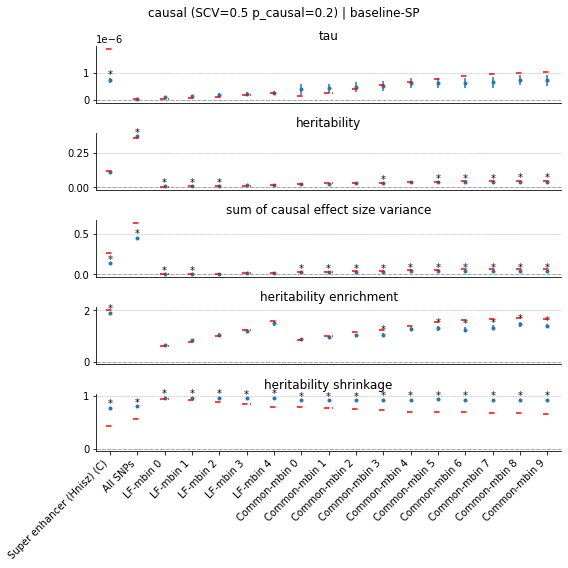

null_h2g50_p20 md_bsl 17


,term,truth,empi.mean,empi.se
AN:SuperEnhancer_Hnisz_common,tau,1.353052e-06,1.330651e-06,3.390594e-08
AN:all,tau,4.898668e-08,5.207521e-08,1.921670e-09
AN:SuperEnhancer_Hnisz_common,heritability,1.933670e-01,1.937884e-01,1.757406e-03
AN:all,heritability,4.963853e-01,5.058043e-01,1.563386e-03
AN:SuperEnhancer_Hnisz_common,sum of causal effect size variance,1.965717e-01,1.937884e-01,1.757406e-03
AN:all,sum of causal effect size variance,5.038206e-01,5.058043e-01,1.563386e-03
AN:SuperEnhancer_Hnisz_common,heritability enrichment,2.242794e+00,2.214634e+00,1.819520e-02
AN:all,heritability enrichment,NaN,NaN,NaN
AN:SuperEnhancer_Hnisz_common,SCV enrichment,2.241548e+00,2.214634e+00,1.819520e-02
AN:all,SCV enrichment,NaN,NaN,NaN


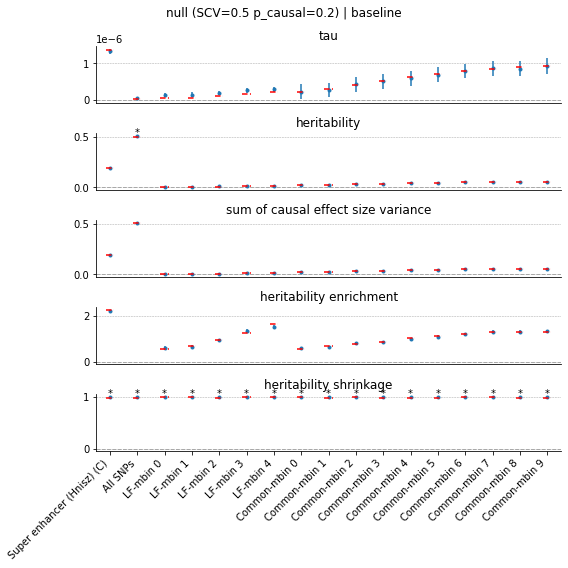

causal_h2g50_p20 md_bsl 17


,term,truth,empi.mean,empi.se
AN:SuperEnhancer_Hnisz_common,tau,1.903829e-06,5.211117e-07,2.808675e-08
AN:all,tau,5.889879e-08,6.773703e-08,2.024938e-09
AN:SuperEnhancer_Hnisz_common,heritability,1.161116e-01,1.034064e-01,1.786901e-03
AN:all,heritability,3.577296e-01,3.638755e-01,1.294048e-03
AN:SuperEnhancer_Hnisz_common,sum of causal effect size variance,2.653675e-01,1.034064e-01,1.786901e-03
AN:all,sum of causal effect size variance,6.423209e-01,3.638755e-01,1.294048e-03
AN:SuperEnhancer_Hnisz_common,heritability enrichment,2.018719e+00,1.841683e+00,2.884860e-02
AN:all,heritability enrichment,NaN,NaN,NaN
AN:SuperEnhancer_Hnisz_common,SCV enrichment,2.358191e+00,1.841683e+00,2.884860e-02
AN:all,SCV enrichment,NaN,NaN,NaN


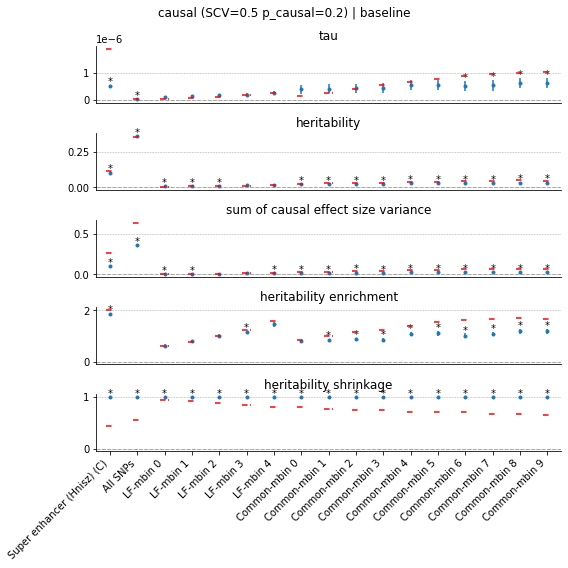

In [8]:
# tau, h2, scv, h2_enrich, h2_shrink, stratified by MAF
for simu,md in [
    ['null_h2g50_p20', 'md_prox_gene_fct_all_ld'],
    ['causal_h2g50_p20', 'md_prox_gene_fct_all_ld'],
    ['null_h2g50_p20', 'md_bsl'],
    ['causal_h2g50_p20', 'md_bsl'],]:
    temp_df = DIC_SUMMARY[simu][md]
    plot_list = [x for x in temp_df.index[(~temp_df['truth'].isna()) & (temp_df['term_identifier']=='scv')]]
    plot_list = [
        'AN:SuperEnhancer_Hnisz_common', 'AN:all',
        'AN:mbin0_lf', 'AN:mbin1_lf', 'AN:mbin2_lf', 'AN:mbin3_lf', 'AN:mbin4_lf',
        'AN:mbin0_common', 'AN:mbin1_common', 'AN:mbin2_common', 'AN:mbin3_common', 'AN:mbin4_common',
        'AN:mbin5_common', 'AN:mbin6_common', 'AN:mbin7_common', 'AN:mbin8_common', 'AN:mbin9_common',
    ]
    print(simu, md, len(plot_list))
    temp_df_show = temp_df.loc[temp_df.index.isin(['AN:SuperEnhancer_Hnisz_common', 'AN:all'])].copy()
    display(temp_df_show[['term', 'truth', 'empi.mean', 'empi.se']])
    plt.figure(figsize=[8, 8])
    for i_plot,temp in enumerate([
        ['tau', 'tau', 0], 
        ['tau', 'h2', 0], 
        ['tau', 'scv', 0], 
        ['tau', 'h2_enrich', 1], 
        ['tau', 'h2_shrink', 1], 
    ]):
        res,term,null_val = temp
        ind_select = DIC_SUMMARY[simu][md]['term_identifier']==term
        df_plot = DIC_SUMMARY[simu][md].loc[ind_select].copy()
        
        df_plot['empi.bias.p'] = ldspec.util.zsc2pval(
            (df_plot['empi.mean']-df_plot['truth']) / df_plot['empi.se']
        )
        df_plot['empi.bias.fwer'] = df_plot['empi.bias.p'] * 165
        df_plot['empi.bias.sig_str'] = ['*' if x<0.05 else '' for x in df_plot['empi.bias.fwer']]

        ax = plt.subplot(5,1,i_plot+1)
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        
        row_list = plot_list
        plt.errorbar(np.arange(len(row_list)), df_plot.loc[row_list, 'empi.mean'],
                     yerr=df_plot.loc[row_list, 'empi.se']*1.96, fmt= '.', zorder=10)
        for i_row,row in enumerate(row_list):
            plt.plot([i_row-0.15, i_row+0.15], [df_plot.loc[row, 'truth'], df_plot.loc[row, 'truth']],
                     '--', color='r', zorder=15)
            plt.text(i_row, df_plot.loc[row, 'empi.mean'] + df_plot.loc[row, 'empi.se'] * 1.96,
                     df_plot.loc[row, 'empi.bias.sig_str'], ha='center') 

        plt.plot([-0.5, len(plot_list)-0.5], [0, 0], "--", linewidth=1, zorder=0, color="darkgrey")
        plt.xlim([-0.5, len(plot_list)-0.5]) 
        plt.grid(axis='y', linewidth=0.5, linestyle='--', color='darkgrey', zorder=0)
            
        plt.title(DIC_NAME[term])         
        if i_plot < 4:
            plt.xticks([], [])
        if i_plot == 4:
            plt.xticks(np.arange(len(plot_list)), [DIC_NAME[x] for x in plot_list], rotation=45, ha='right')
    
    plt.suptitle('%s | %s' % (dic_name[simu], DIC_NAME[md] if md in DIC_NAME else md))
    plt.tight_layout()
    plt.savefig(FIG_PATH + '/other.%s.%s.tau.pdf'%(simu,md))
    plt.show()
#     break    

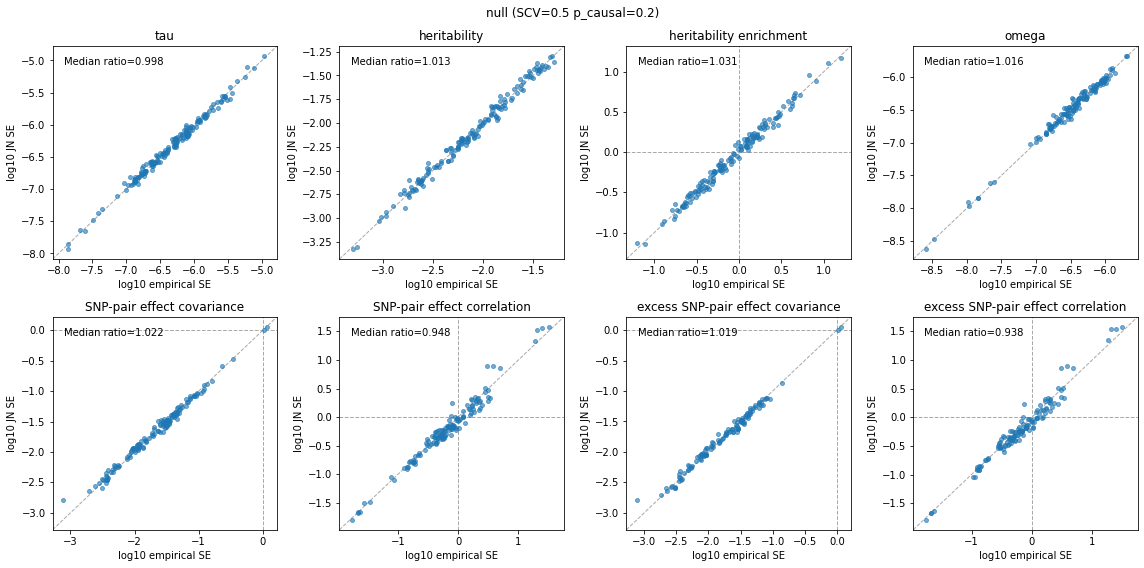

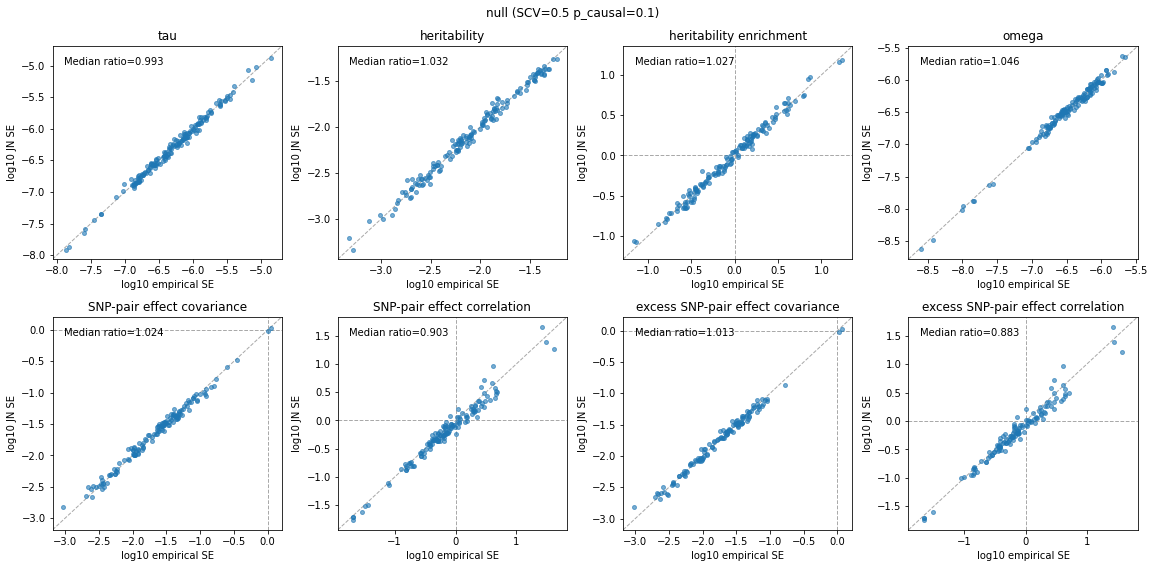

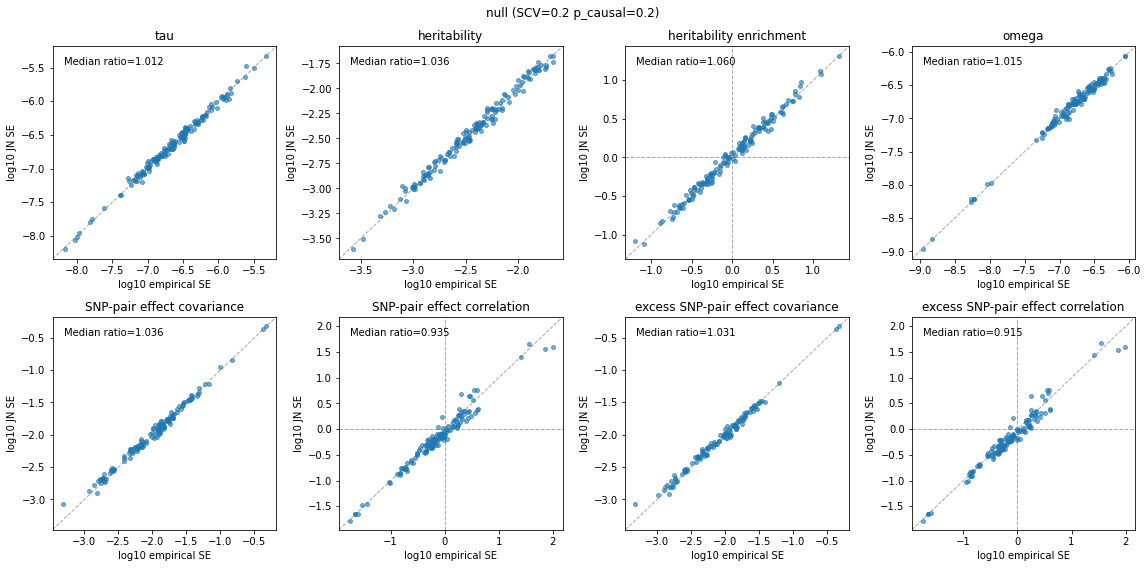

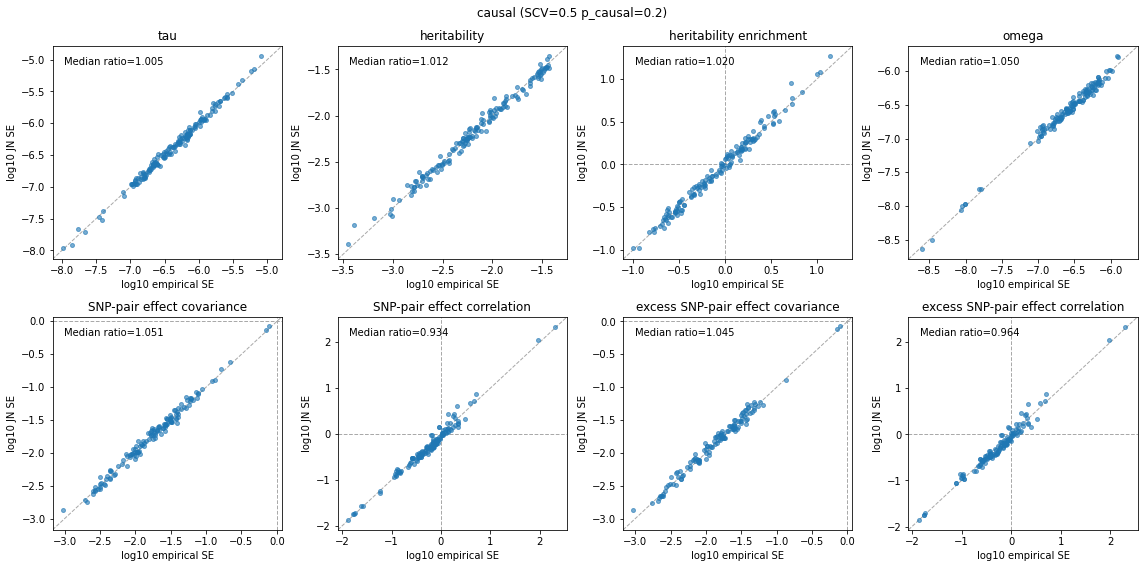

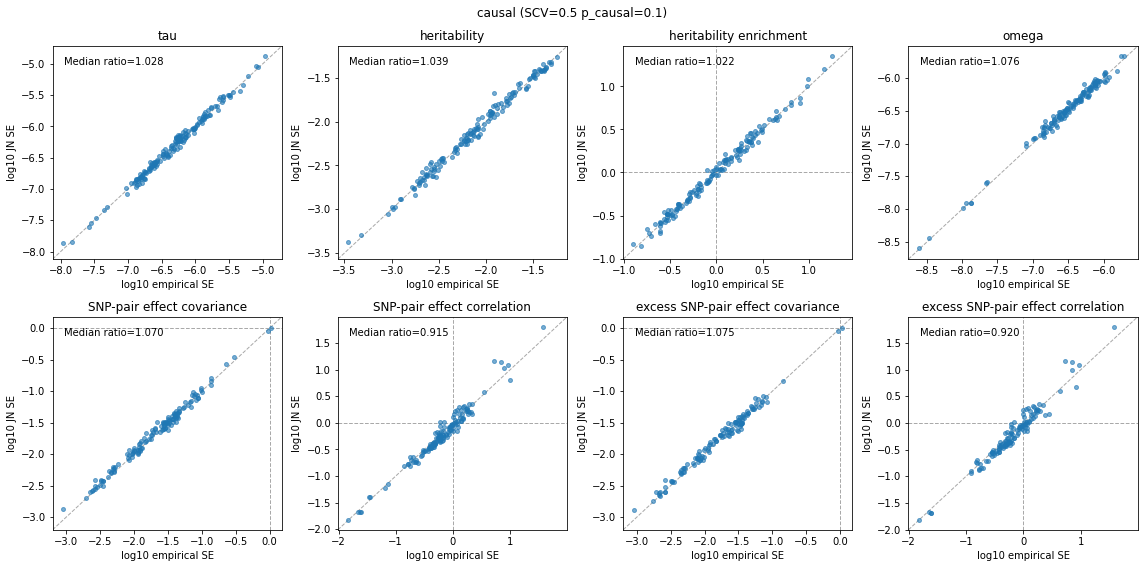

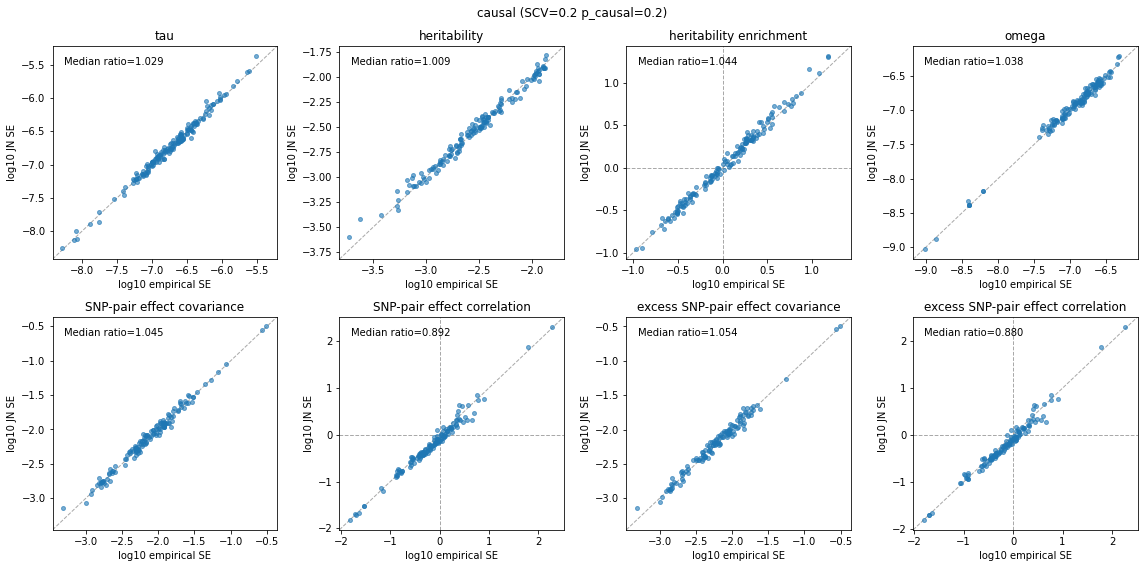

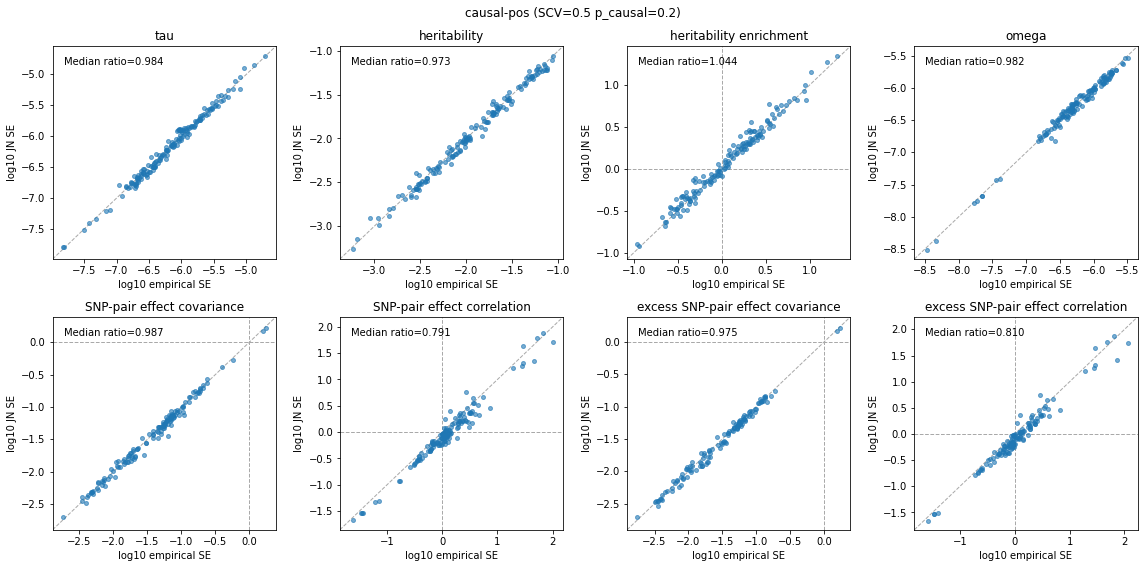

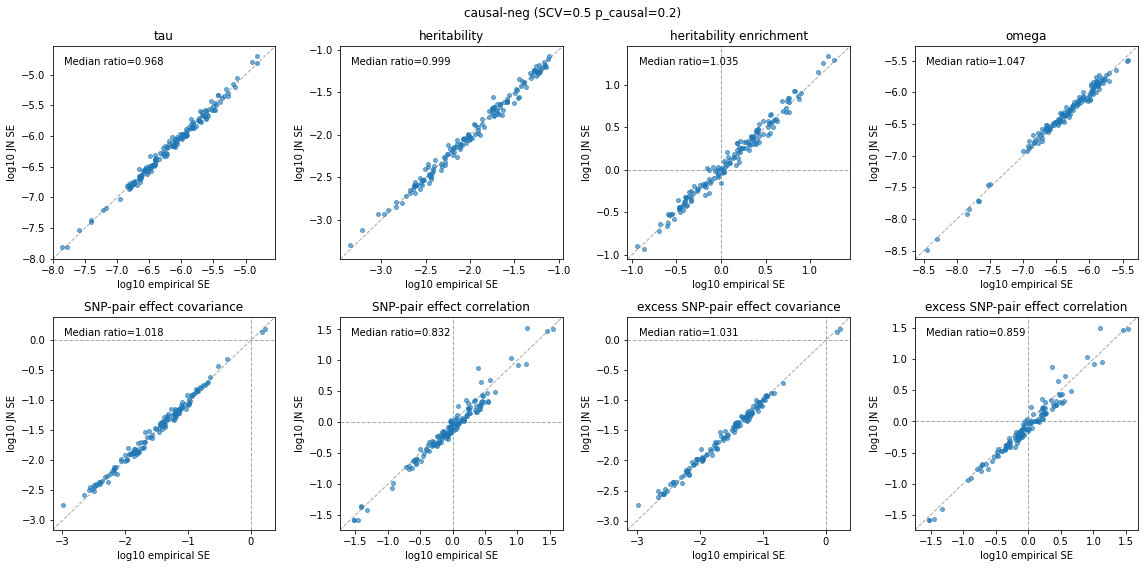

In [9]:
# CIs (check, not in the paper)
for simu,md in simu_md_list: 
    plt.figure(figsize=[16,8])
    plt.suptitle(dic_name[simu])
    for i_plot,term in enumerate(['tau', 'h2', 'h2_enrich', 'omega', 'cov', 'cor', 'ecov', 'ecor']):
        plt.subplot(2,4,i_plot+1)
        ind_select = DIC_SUMMARY[simu][md]['term_identifier']==term
        df_plot = DIC_SUMMARY[simu][md].loc[ind_select, ['jnse', 'empi.se']].copy()
        df_plot['jnse'] *= np.sqrt(dic_n_rep[simu])
        df_plot['empi.se'] *= np.sqrt(dic_n_rep[simu])
        df_plot = df_plot.loc[df_plot['empi.se']>0]
        
        plt.scatter(np.log10(df_plot['empi.se']), np.log10(df_plot['jnse']), alpha=0.6, s=16, zorder=5)
        xmin,xmax = plt.xlim()
        ymin,ymax = plt.ylim()
        min_,max_ = min(xmin,ymin), max(xmax, ymax)
        plt.plot([min_,max_], [0, 0], '--', linewidth=1, zorder=0, color='darkgray')
        plt.plot([0, 0], [min_,max_], '--', linewidth=1, zorder=0, color='darkgray')
        plt.plot([min_,max_], [min_, max_], '--', linewidth=1, zorder=0, color='darkgray')
        plt.xlim([min_,max_])
        plt.ylim([min_,max_])
        plt.xlabel('log10 empirical SE')
        plt.ylabel('log10 JN SE')
        plt.text(min_+0.05*(max_-min_), max_-0.05*(max_-min_), 
                 'Median ratio=%0.3f'%np.median(df_plot['jnse'] / df_plot['empi.se']), 
                 ha='left', va='top')
        plt.title(DIC_NAME[term])
    plt.tight_layout()
    plt.show()

### LDSC on null_h2g50_p20 and causal_h2g50_p20 

In [10]:
# Check ldsc results
def parse_log(fpath):
    with open(fpath, 'r') as f:
        h2,h2_se = 0,0
        for line in f:
            if 'Total Observed scale h2' in line:
                line = line.replace('Total Observed scale h2:','').replace(')','').strip()
                h2 = float(line.split('(')[0])
                h2_se = float(line.split('(')[1])
    return h2,h2_se

DIC_RES_PATH_LDSC = {
    'null_h2g50_p20' : DATA_PATH + '/null_h2g50_p20.ldsc/rep@',
    'causal_h2g50_p20' : DATA_PATH + '/causal_h2g50_p20.ldsc/rep@',
}

dic_res_ldsc = {}
dic_res_ldsc_h2 = {}
for simu in DIC_RES_PATH_LDSC:
    dic_res_ldsc[simu] = {}
    dic_res_ldsc_h2[simu] = pd.DataFrame(index=np.arange(dic_n_rep[simu]), columns=['h2', 'h2_se'])
    for i_rep in range(dic_n_rep[simu]):
        res_file = DIC_RES_PATH_LDSC[simu].replace('@', '%d'%i_rep) + '.results'
        log_file = DIC_RES_PATH_LDSC[simu].replace('@', '%d'%i_rep) + '.log'
        if os.path.exists(res_file):
            temp_df = pd.read_csv(res_file, sep='\t', index_col=0)
            temp_df.index = [x.replace('LD:','').replace('_0','') for x in temp_df.index]
            dic_res_ldsc[simu][i_rep] = temp_df.copy()
            h2,h2_se = parse_log(log_file)
            dic_res_ldsc_h2[simu].loc[i_rep, ['h2', 'h2_se']] = h2,h2_se
        else:
            print("Missing %-10s rep%d" % (simu, i_rep))

In [11]:
# Supp. Table for null and causal simulations and all quantities
term_list = [['tau', 'tau', 0], ['tau', 'h2', 0], ['tau', 'h2_enrich', 1]]
dic_term_map_ldsc = {
    'tau' : 'Coefficient', 'tau_se' : 'Coefficient_std_error', 
    'h2' : 'Prop._h2', 'h2_se' : 'Prop._h2_std_error',
    'h2_enrich' : 'Enrichment', 'h2_enrich_se' : 'Enrichment_std_error',
}
col_list = [
    'annot', 'term', 'term_identifier', 'truth', 'jnse', 
    'empi.mean', 'empi.se', 'empi.p', 'empi.fwer', 'empi.sig_str',
]

DIC_SUMMARY_LDSC = {}
for simu in DIC_RES_PATH_LDSC:
# for simu in ['null_h2g50_p20']:
    DIC_SUMMARY_LDSC[simu] = None   
    for res,term,null_val in term_list:
        term_ldsc = dic_term_map_ldsc[term]
        term_se_ldsc = dic_term_map_ldsc['%s_se'%term]
        temp_df = pd.DataFrame(index=dic_res_ldsc[simu][0].index, columns=col_list, dtype=float)
        temp_df['annot'] = temp_df.index
        temp_df['term'] = DIC_NAME[term]
        temp_df['term_identifier'] = term
        # Truth from DIC_SUMMARY
        temp_df['truth'] = DIC_SUMMARY[simu][md]['truth'].loc[DIC_SUMMARY[simu][md]['term_identifier']==term]
        for row in temp_df.index:
            # empi.mean & empi.se
            v_ = [dic_res_ldsc[simu][x].loc[row, term_ldsc] for x in range(dic_n_rep[simu])]
            if term == 'h2':
                h2 = dic_res_ldsc_h2[simu]['h2'].mean()
                v_ = [x * h2 for x in v_]
            temp_df.loc[row, 'empi.mean'] = np.mean(v_)
            temp_df.loc[row, 'empi.se'] = np.std(v_) / np.sqrt(dic_n_rep[simu])
            # jnse
            v_se_ = [dic_res_ldsc[simu][x].loc[row, term_se_ldsc] for x in range(dic_n_rep[simu])]
            if term == 'h2':
                h2 = dic_res_ldsc_h2[simu]['h2'].mean()
                v_se_ = [x * h2 for x in v_se_]
            temp_df.loc[row, 'jnse'] = np.sqrt(np.mean(np.array(v_se_)**2)) / np.sqrt(dic_n_rep[simu])
                
        # multiple testing: empi
        temp_z = np.array((temp_df['empi.mean']-null_val) / temp_df['empi.se'])
        temp_df['empi.p'] = ldspec.util.zsc2pval(temp_z)
        temp_df['empi.fwer'] = temp_df['empi.p'] * temp_df.shape[0]
        temp_df['empi.sig_str'] = ['*' if x<0.05 else '' for x in temp_df['empi.fwer']]

        if DIC_SUMMARY_LDSC[simu] is None:
            DIC_SUMMARY_LDSC[simu] = temp_df.copy()
        else:
            DIC_SUMMARY_LDSC[simu] = pd.concat([DIC_SUMMARY_LDSC[simu], temp_df], axis=0)

null_h2g50_p20 ldsc 17


,term,truth,empi.mean,empi.se
AN:SuperEnhancer_Hnisz_common,tau,1.353052e-06,1.214125e-06,2.516880e-08
AN:all,tau,4.898668e-08,7.125314e-08,1.516712e-09
AN:SuperEnhancer_Hnisz_common,heritability,1.933670e-01,1.922217e-01,1.376097e-03
AN:all,heritability,4.963853e-01,5.878840e-01,4.851520e-09
AN:SuperEnhancer_Hnisz_common,heritability enrichment,2.242794e+00,3.812818e+00,2.729560e-02
AN:all,heritability enrichment,NaN,1.000000e+00,8.252513e-09


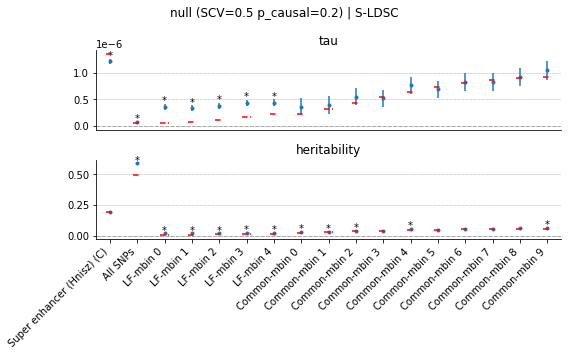

causal_h2g50_p20 ldsc 17


,term,truth,empi.mean,empi.se
AN:SuperEnhancer_Hnisz_common,tau,1.903829e-06,5.038937e-07,2.491142e-08
AN:all,tau,5.889879e-08,8.053670e-08,1.937706e-09
AN:SuperEnhancer_Hnisz_common,heritability,1.161116e-01,1.049913e-01,1.483474e-03
AN:all,heritability,3.577296e-01,4.199200e-01,3.186097e-09
AN:SuperEnhancer_Hnisz_common,heritability enrichment,2.018719e+00,2.915560e+00,4.119541e-02
AN:all,heritability enrichment,NaN,1.000000e+00,7.587391e-09


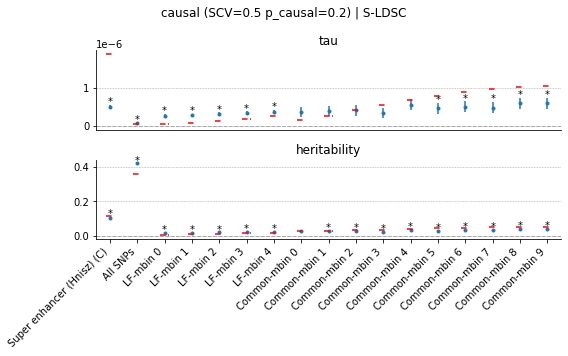

In [12]:
# tau, h2, stratified by MAF
md = 'ldsc'
for simu in ['null_h2g50_p20', 'causal_h2g50_p20']:
    temp_df = DIC_SUMMARY_LDSC[simu]
    plot_list = [
        'AN:SuperEnhancer_Hnisz_common', 'AN:all',
        'AN:mbin0_lf', 'AN:mbin1_lf', 'AN:mbin2_lf', 'AN:mbin3_lf', 'AN:mbin4_lf',
        'AN:mbin0_common', 'AN:mbin1_common', 'AN:mbin2_common', 'AN:mbin3_common', 'AN:mbin4_common',
        'AN:mbin5_common', 'AN:mbin6_common', 'AN:mbin7_common', 'AN:mbin8_common', 'AN:mbin9_common',
    ]
    print(simu, md, len(plot_list))
    temp_df_show = temp_df.loc[temp_df.index.isin(['AN:SuperEnhancer_Hnisz_common', 'AN:all'])].copy()
    display(temp_df_show[['term', 'truth', 'empi.mean', 'empi.se']])
    plt.figure(figsize=[8, 5])
    for i_plot,temp in enumerate([ ['tau', 'tau', 0], ['tau', 'h2', 0]]):
        res,term,null_val = temp
        ind_select = DIC_SUMMARY_LDSC[simu]['term_identifier']==term
        df_plot = DIC_SUMMARY_LDSC[simu].loc[ind_select].copy()
        
        df_plot['empi.bias.p'] = ldspec.util.zsc2pval(
            (df_plot['empi.mean']-df_plot['truth']) / df_plot['empi.se']
        )
        df_plot['empi.bias.fwer'] = df_plot['empi.bias.p'] * 165
        df_plot['empi.bias.sig_str'] = ['*' if x<0.05 else '' for x in df_plot['empi.bias.fwer']]

        ax = plt.subplot(2,1,i_plot+1)
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        
        row_list = plot_list
        plt.errorbar(np.arange(len(row_list)), df_plot.loc[row_list, 'empi.mean'],
                     yerr=df_plot.loc[row_list, 'empi.se']*1.96, fmt= '.', zorder=10)
        for i_row,row in enumerate(row_list):
            plt.plot([i_row-0.15, i_row+0.15], [df_plot.loc[row, 'truth'], df_plot.loc[row, 'truth']],
                     '--', color='r', zorder=15)
            plt.text(i_row, df_plot.loc[row, 'empi.mean'] + df_plot.loc[row, 'empi.se'] * 1.96,
                     df_plot.loc[row, 'empi.bias.sig_str'], ha='center') 

        plt.plot([-0.5, len(plot_list)-0.5], [0, 0], "--", linewidth=1, zorder=0, color="darkgrey")
        plt.xlim([-0.5, len(plot_list)-0.5]) 
        plt.grid(axis='y', linewidth=0.5, linestyle='--', color='darkgrey', zorder=0)
            
        plt.title(DIC_NAME[term])         
        if i_plot < 1:
            plt.xticks([], [])
        if i_plot == 1:
            plt.xticks(np.arange(len(plot_list)), [DIC_NAME[x] for x in plot_list], rotation=45, ha='right')
    
    plt.suptitle('%s | %s' % (dic_name[simu], DIC_NAME[md] if md in DIC_NAME else md))
    plt.tight_layout()
    plt.savefig(FIG_PATH + '/other.%s.%s.tau.pdf'%(simu,md))
    plt.show()
#     break    

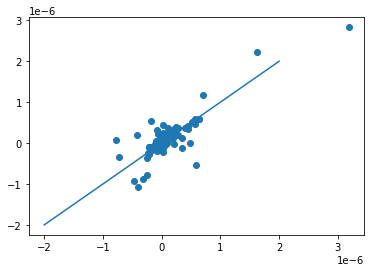

In [13]:
# debug: LDSC vs. LDSPEC-baseline
simu = 'null_h2g50_p20'
simu = 'causal_h2g50_p20'
plt.figure()
temp_df1 = DIC_SUMMARY[simu]['md_bsl']
temp_df2 = DIC_SUMMARY_LDSC[simu]
plt.scatter(
    temp_df1.loc[temp_df1['term_identifier']=='tau', 'empi.mean'],
    temp_df2.loc[temp_df2['term_identifier']=='tau', 'empi.mean'],
)
plt.plot([-2e-6, 2e-6], [-2e-6, 2e-6])
plt.show()